In [1]:
import os
import torch
import scipy.stats as stats
import numpy as np

# CODE FILES HERE
from models.vae.vae import Encoder, Decoder, Vae, MODEL_NAME
from solver import Solver
from directories import Directories
from dataloader import DataLoader
from plots import plot_losses, plot_gaussian_distributions, plot_rl_kl, plot_latent_space, \
plot_latent_manifold, plot_faces_grid, plot_faces_samples_grid

# SETTINGS HERE
os.environ['CUDA_LAUNCH_BLOCKING'] = "1" # to see the CUDA stack
%matplotlib inline
# for auto-reloading external modules
# see http://stackoverflow.com/questions/1907993/autoreload-of-modules-in-ipython
%load_ext autoreload
%autoreload 2
# supress cluttering warnings in solutions
import warnings
warnings.filterwarnings('ignore')

In [2]:
# setting device on GPU if available, else CPU
device = torch.device('cuda:0' if torch.cuda.is_available() else 'cpu')
print('Using device:', device)
print()

# Additional Info when using cuda
if device.type == 'cuda':
    print(torch.cuda.get_device_name(0))
    print('Memory Usage:')
    print('Allocated:', round(torch.cuda.memory_allocated(0)/1024**3,1), 'GB')
    print('Cached:   ', round(torch.cuda.memory_cached(0)/1024**3,1), 'GB')

Using device: cpu



In [3]:
# Choose the dataset and tune hyperparameters here!
dataset = "MNIST"

batch_size = 128
optimizer = torch.optim.Adam

if dataset == "MNIST":
    epochs = 20
    hidden_dim = 500
    z_dim = 2
    beta = 4 if z_dim == 2 else 4
    batch_norm = True
    lr_scheduler = torch.optim.lr_scheduler.StepLR
    step_config = {
        "step_size" : 200,
        "gamma" : 0.1 # or 0.75
    }
    optim_config = {
        "lr": 1e-3,
        "weight_decay": None
    }
elif dataset == "LFW":
    epochs = 30
    hidden_dim = 700
    z_dim = 40
    beta = 1 if z_dim == 2 else 1
    batch_norm = True
    lr_scheduler = torch.optim.lr_scheduler.StepLR
    step_config = {
        "step_size" : 30,
        "gamma" : 0.1
    }
    optim_config = {
        "lr": 1e-2,
        "weight_decay": None
    }
elif dataset == "FF":
    epochs = 100
    hidden_dim = 200
    z_dim = 2
    beta = 1
    batch_norm = False
    lr_scheduler = torch.optim.lr_scheduler.StepLR
    step_config = {
        "step_size" : 300,
        "gamma" : 0.1
    }
    optim_config = {
        "lr": 1e-2,
        "weight_decay": None
    }

In [4]:
directories = Directories(MODEL_NAME, dataset, z_dim)
data_loader = DataLoader(directories, batch_size, dataset)
model = Vae(data_loader.input_dim, hidden_dim, z_dim, batch_norm)
solver = Solver(model, data_loader, optimizer, z_dim, epochs, beta, step_config, optim_config, lr_scheduler=lr_scheduler)
solver.main()

+++++ START RUN | saved files in vae/MNIST_z=2_2 +++++
====> Epoch: 1 train set loss avg: 483.1581
====> Test set loss avg: 435.3130
60.28 seconds for epoch 1
====> Epoch: 2 train set loss avg: 380.8919
====> Test set loss avg: 366.0183
56.39 seconds for epoch 2
====> Epoch: 3 train set loss avg: 318.4247
====> Test set loss avg: 322.8895
58.05 seconds for epoch 3
====> Epoch: 4 train set loss avg: 277.3193
====> Test set loss avg: 292.4555
76.03 seconds for epoch 4
====> Epoch: 5 train set loss avg: 249.2021
====> Test set loss avg: 274.0125
63.49 seconds for epoch 5
====> Epoch: 6 train set loss avg: 229.4866
====> Test set loss avg: 259.1880
84.60 seconds for epoch 6
====> Epoch: 7 train set loss avg: 215.0678
====> Test set loss avg: 248.4295
70.61 seconds for epoch 7
====> Epoch: 8 train set loss avg: 204.4698
====> Test set loss avg: 241.5197
71.08 seconds for epoch 8
====> Epoch: 9 train set loss avg: 196.4702
====> Test set loss avg: 236.0990
74.28 seconds for epoch 9
====> Epo

In [ ]:
# Insert name of model here if want to load a model, e.g. solver.save_model_dir + "/VAE_MNIST_train_loss=151.39_z=2.pt"
#solver = torch.load(solver.save_model_dir + "/VAE_MNIST_train_loss=97.15_z=20.pt")
#solver.model.eval()

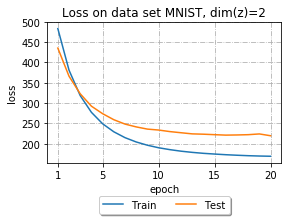

In [5]:
# Plotting train and test losses for all epochs
plot_losses(solver, solver.train_loss_history["train_loss_acc"], solver.test_loss_history)

epoch: 1, mu(z): -0.0023, stddev(z): 1.0262, var(z): 1.0532, var(mu(z)): 0.8400 E[var(q(z|x)]: 0.2132
epoch: 6, mu(z): 0.0003, stddev(z): 1.0045, var(z): 1.0090, var(mu(z)): 0.9662 E[var(q(z|x)]: 0.0392
epoch: 11, mu(z): -0.0011, stddev(z): 0.9988, var(z): 0.9975, var(mu(z)): 0.9646 E[var(q(z|x)]: 0.0282
epoch: 20, mu(z): -0.0007, stddev(z): 1.0016, var(z): 1.0031, var(mu(z)): 0.9748 E[var(q(z|x)]: 0.0226


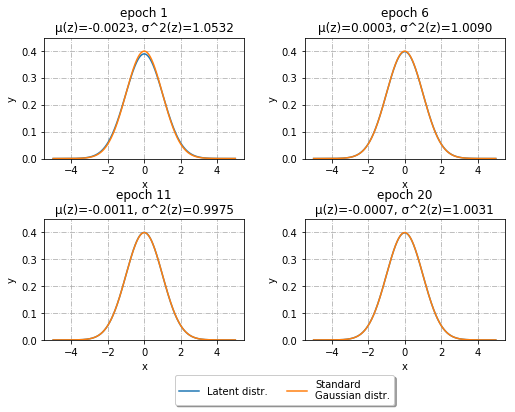

In [6]:
# Plotting the gaussian of z space and some metrics about the space
plot_gaussian_distributions(solver, len(solver.train_loss_history["train_loss_acc"]))

epoch: 1, train_loss: 483.16, test_loss: 435.31, recon. loss: 475.95, KL div.: 7.21
overfitting: 47.85
epoch: 2, train_loss: 380.89, test_loss: 366.02, recon. loss: 371.13, KL div.: 9.77
overfitting: 14.87
epoch: 3, train_loss: 318.42, test_loss: 322.89, recon. loss: 307.03, KL div.: 11.39
overfitting: 4.46
epoch: 4, train_loss: 277.32, test_loss: 292.46, recon. loss: 264.86, KL div.: 12.46
overfitting: 15.14
epoch: 5, train_loss: 249.20, test_loss: 274.01, recon. loss: 236.05, KL div.: 13.15
overfitting: 24.81
epoch: 6, train_loss: 229.49, test_loss: 259.19, recon. loss: 215.78, KL div.: 13.71
overfitting: 29.70
epoch: 7, train_loss: 215.07, test_loss: 248.43, recon. loss: 200.92, KL div.: 14.15
overfitting: 33.36
epoch: 8, train_loss: 204.47, test_loss: 241.52, recon. loss: 189.97, KL div.: 14.50
overfitting: 37.05
epoch: 9, train_loss: 196.47, test_loss: 236.10, recon. loss: 181.68, KL div.: 14.79
overfitting: 39.63
epoch: 10, train_loss: 190.24, test_loss: 233.80, recon. loss: 175.

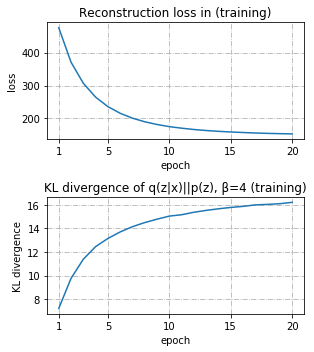

In [7]:
# Monitoring the reconstruction loss (likelihood lower bound) and KL divergence
DEBUG = 1
if DEBUG:
    for epoch, train_loss, test_loss, rl, kl in zip(solver.train_loss_history["epochs"], \
                             solver.train_loss_history["train_loss_acc"], \
                             solver.test_loss_history, \
                             solver.train_loss_history["recon_loss_acc"], \
                             solver.train_loss_history["kl_diverg_acc"]):
        print("epoch: {}, train_loss: {:.2f}, test_loss: {:.2f}, recon. loss: {:.2f}, KL div.: {:.2f}".format(
            epoch, train_loss, test_loss, rl, kl))
        print("overfitting: {:.2f}".format(abs(test_loss-train_loss)))
plot_rl_kl(solver, solver.train_loss_history["recon_loss_acc"], solver.train_loss_history["kl_diverg_acc"])

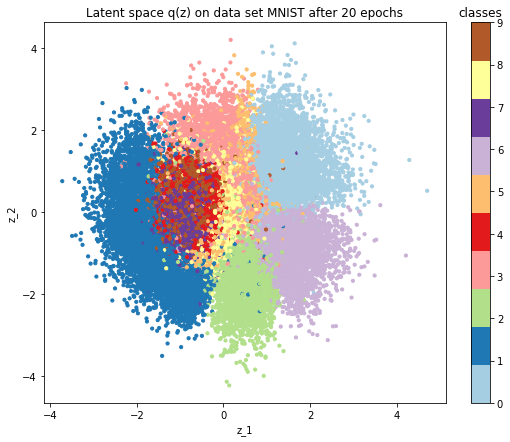

In [8]:
# visualize q(z) (latent space z)
if solver.z_dim == 2:
    if solver.data_loader.with_labels:
        plot_latent_space(solver, solver.z_space, var="z", title="classes", labels=solver.data_labels)
    else:
        plot_latent_space(solver, solver.z_space, var="z")
else:
    print("Plot of latent space not possible as dimension of z is not 2")

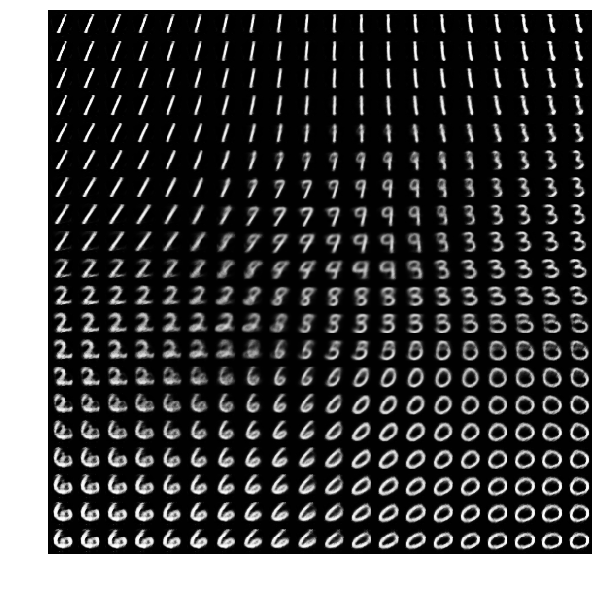

In [10]:
# Visualizations of learned data manifold for generative models with two-dimensional latent space
if solver.z_dim == 2:
    if solver.data_loader.dataset == "MNIST":
        n = 20
        grid_x = grid_y = np.linspace(-3, 3, n)
        plot_latent_manifold(solver, "bone", grid_x, grid_y, n)
    if solver.data_loader.dataset == "LFW" or solver.data_loader.dataset == "FF":
        n = 10
        grid_x = grid_y = np.linspace(-3, 3, n)
        plot_latent_manifold(solver, "gray", grid_x, grid_y, n, fig_size=(10, 8))
else:
    print("Plot is not possible as dimension of z is not 2")

In [ ]:
# plots real faces and in grid samples
if solver.data_loader.dataset == "LFW" or solver.data_loader.dataset == "FF":
    n = 225
    n_cols = 15
    plot_faces_grid(n, n_cols, solver)
    plot_faces_samples_grid(n, n_cols, solver)

In [ ]:
last_train_loss = solver.train_loss_history["train_loss_acc"][-1]
torch.save(solver, solver.data_loader.directories.result_dir + "/model_VAE_" + solver.data_loader.dataset + "_train_loss=" + "{0:.2f}".format(last_train_loss) + "_z=" + str(solver.z_dim) + ".pt")